# A. IMPORT & SETUP

Bagian ini berisi proses persiapan lingkungan kerja, termasuk pemasangan dependensi, import library yang diperlukan, serta mounting penyimpanan untuk mengakses dataset. Langkah ini memastikan seluruh komponen teknis telah siap digunakan sebelum melanjutkan ke tahap pemrosesan data dan pelatihan model.

In [29]:
!pip install ultralytics


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 362, in run
    resolver = self.make_resolver(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 177, in make_resolver
    return pip._internal.resolution.resolvelib.resolver.Resolver(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 58, in __init__
    self.factory = Factory(
                   ^^^^^^^^
  File "/usr/local/lib/py

In [30]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# dasar libraries
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

In [32]:
# path utama dataset — sesuaikan jika berbeda
BASE_PATH = '/content/drive/MyDrive/Capstone 4 Imam/construction safety'

# helper: print isi folder root dataset
print("Root path:", BASE_PATH)
print("Isi folder root:")
print(os.listdir(BASE_PATH))

Root path: /content/drive/MyDrive/Capstone 4 Imam/construction safety
Isi folder root:
['README.roboflow.txt', 'data.yaml', 'README.dataset.txt', 'valid', 'train', 'test']


# B. DATA PREPARATION

Tahapan ini melakukan verifikasi struktur dataset dan memastikan seluruh file gambar serta anotasi telah tersusun sesuai ketentuan YOLO. Pemeriksaan meliputi pengecekan folder train, validation, test, serta file konfigurasi data.yaml. Persiapan yang tepat pada tahap ini memastikan proses pelatihan berjalan tanpa kendala.

In [20]:


# 1) Baca data.yaml untuk dapatkan class names dan path (jika ada)
yaml_path = os.path.join(BASE_PATH, 'data.yaml')
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_cfg = yaml.safe_load(f)
    print("Loaded data.yaml:")
    print(data_cfg)
    class_names = data_cfg.get('names') or data_cfg.get('names')  # names can be list or mapping
else:
    print("data.yaml tidak ditemukan di", yaml_path)
    # kalau tidak ada, kamu bisa definisikan manually:
    class_names = ["person","helmet","vest","no-helmet","no-vest"]
    print("Gunakan class default:", class_names)





Loaded data.yaml:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 5, 'names': ['helmet', 'no-helmet', 'no-vest', 'person', 'vest'], 'roboflow': {'workspace': 'personal-project-kej16', 'project': 'construction-safety-gsnvb-jl6el', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/personal-project-kej16/construction-safety-gsnvb-jl6el/dataset/1'}}


In [21]:
# 2) Temukan folder images dan labels (train/val/test). Adaptif: cek beberapa kemungkinan nama folder.
possible_splits = ['train','val','validation','test']
found = {}
for s in possible_splits:
    img_dir = os.path.join(BASE_PATH, s, 'images')
    lbl_dir = os.path.join(BASE_PATH, s, 'labels')
    if os.path.isdir(img_dir):
        found[s] = {'images': img_dir, 'labels': lbl_dir if os.path.isdir(lbl_dir) else None}

print("\nFolder yang terdeteksi:")
for k,v in found.items():
    print(k, "-> images:", v['images'], "labels:", v['labels'])


Folder yang terdeteksi:
train -> images: /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images labels: /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/labels
test -> images: /content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images labels: /content/drive/MyDrive/Capstone 4 Imam/construction safety/test/labels


In [22]:
# 3) Hitung jumlah gambar & label per split, dan cek missing label files
summary = {}
for split, paths in found.items():
    imgs = sorted(glob.glob(os.path.join(paths['images'], '*.*')))  # ambil semua ekstensi
    n_img = len(imgs)
    n_lbl = 0
    missing_labels = []
    empty_labels = []
    if paths['labels'] is not None:
        for img_path in imgs:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            lbl_path = os.path.join(paths['labels'], img_name + '.txt')
            if os.path.exists(lbl_path):
                # periksa isi file label
                if os.path.getsize(lbl_path) == 0:
                    empty_labels.append(lbl_path)
                else:
                    n_lbl += 1
            else:
                missing_labels.append(lbl_path)
    else:
        # Tidak ada folder labels
        missing_labels = ['labels folder not found']
    summary[split] = {
        'n_images': n_img,
        'n_label_files_present': n_lbl,
        'n_missing_labels': len(missing_labels),
        'n_empty_label_files': len(empty_labels),
        'missing_examples': missing_labels[:5],
        'empty_examples': empty_labels[:5]
    }

print("\nSummary per split:")
for s,v in summary.items():
    print(s, v)



Summary per split:
train {'n_images': 997, 'n_label_files_present': 997, 'n_missing_labels': 0, 'n_empty_label_files': 0, 'missing_examples': [], 'empty_examples': []}
test {'n_images': 90, 'n_label_files_present': 90, 'n_missing_labels': 0, 'n_empty_label_files': 0, 'missing_examples': [], 'empty_examples': []}


# C. Exploratory Data Analysis


Pada bagian ini dilakukan analisis awal terhadap dataset untuk memahami karakteristik data, seperti keberagaman gambar, kualitas anotasi, dan distribusi kelas. EDA membantu memastikan bahwa dataset memiliki label yang konsisten dan representatif sehingga model dapat belajar secara optimal.

In [23]:

def parse_yolo_label(lbl_path):
    """Return list of tuples (class_id, x_c, y_c, w, h) as floats"""
    items = []
    if not os.path.exists(lbl_path):
        return items
    with open(lbl_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cid = int(float(parts[0]))
                coords = list(map(float, parts[1:5]))
                items.append((cid, *coords))
    return items

# 1) Hitung distribusi class untuk entire dataset (menggunakan folder labels yang ada)
from collections import Counter
class_counter = Counter()
total_boxes = 0
for split, paths in found.items():
    lbl_dir = paths['labels']
    if lbl_dir and os.path.isdir(lbl_dir):
        for lbl_file in glob.glob(os.path.join(lbl_dir, '*.txt')):
            objs = parse_yolo_label(lbl_file)
            for o in objs:
                class_counter[o[0]] += 1
                total_boxes += 1

print("\nTotal bounding boxes:", total_boxes)
print("Class counts (index -> count):")
for idx,count in class_counter.items():
    name = class_names[idx] if idx < len(class_names) else f"cls{idx}"
    print(f"  {idx} ({name}): {count}")




Total bounding boxes: 7009
Class counts (index -> count):
  0 (helmet): 2311
  3 (person): 2576
  4 (vest): 1202
  2 (no-vest): 802
  1 (no-helmet): 118



Menampilkan contoh gambar beserta anotasi (jika ada):
-> /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0697_jpg.rf.69e5a4ce4087d9b35dfa7c6b85e220b1.jpg


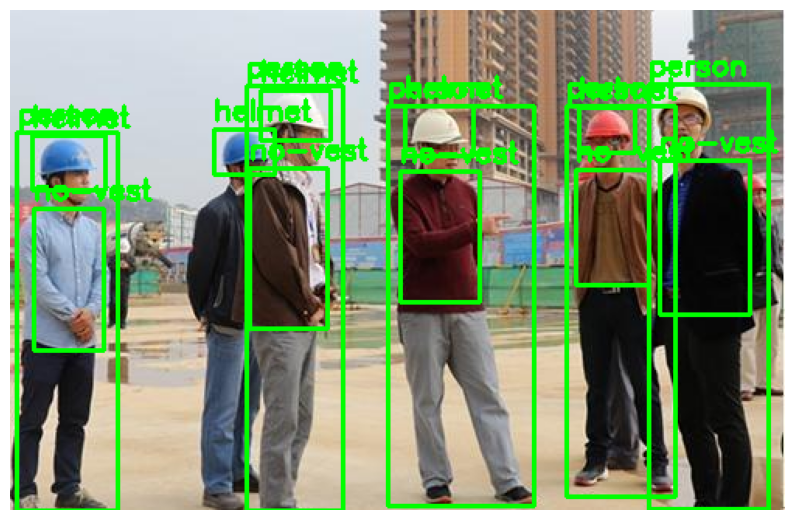

-> /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0809_jpg.rf.05a37661c24313270258cad01cb54f9e.jpg


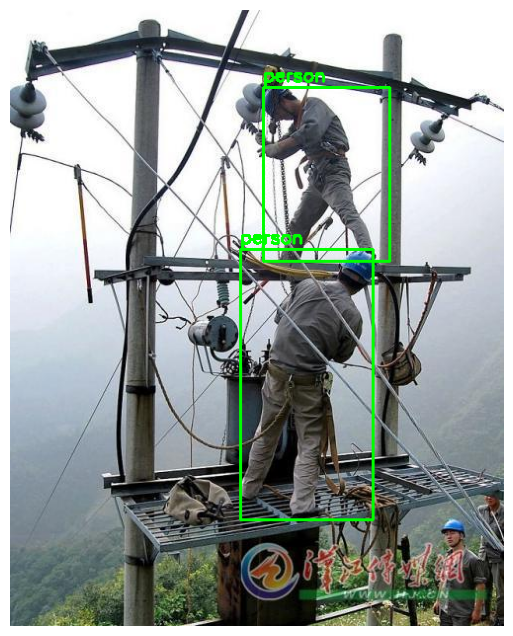

-> /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_1113_jpg.rf.7ca8b74f61e58ab7891da447f35620b0.jpg


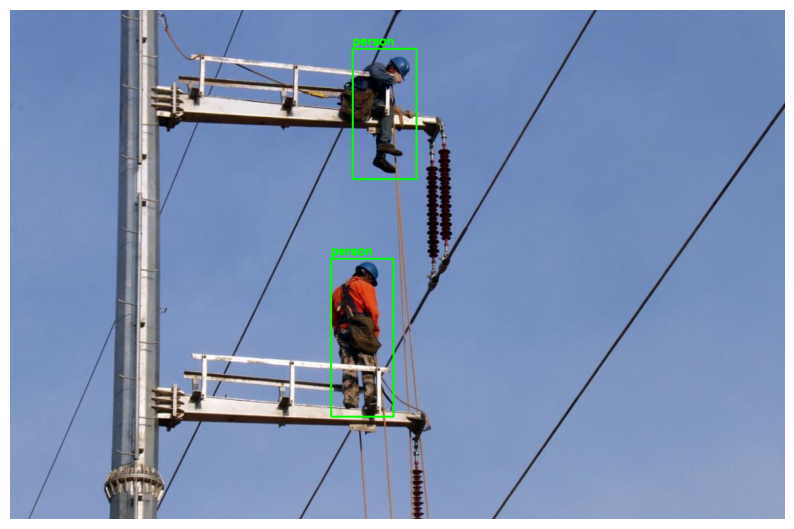

-> /content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images/ppe_0133_jpg.rf.b831af0b1bc9c11e0a06dd7719d6a4b4.jpg


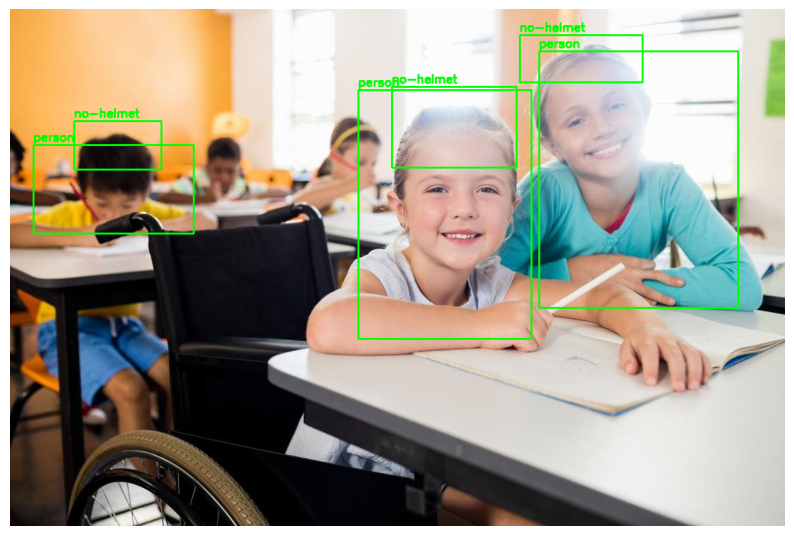

-> /content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images/ppe_0408_jpg.rf.5b697c4b5cef06c96e65c65a5bec2bab.jpg


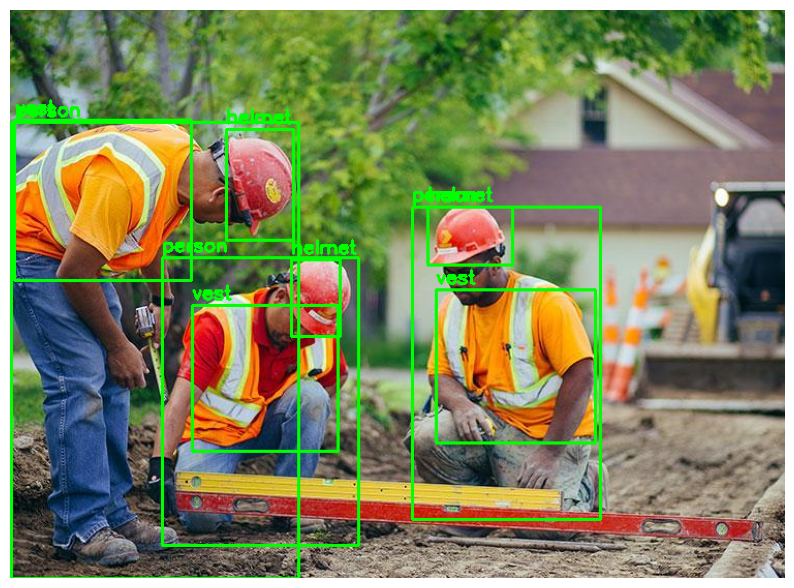

-> /content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images/ppe_0872_jpg.rf.90d9c2c1a43ad8188834fff8b4a6faf3.jpg


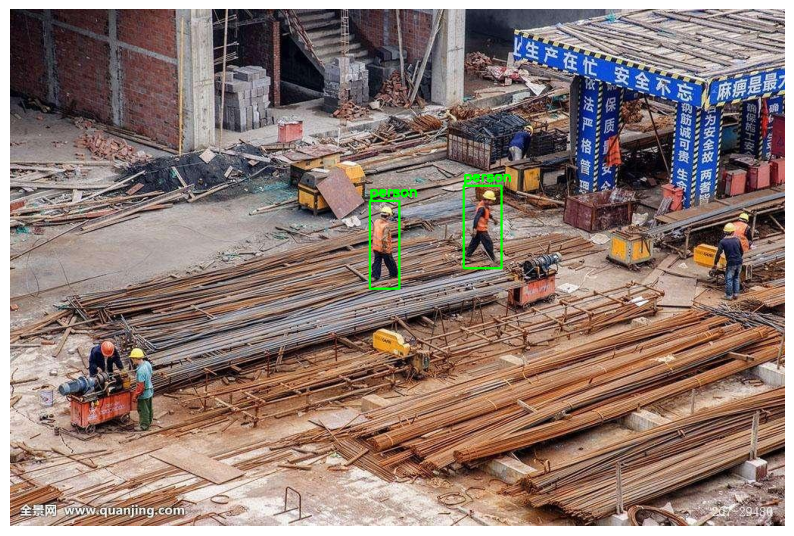

In [24]:
# 2) Visualisasi contoh gambar dengan overlay boxes
def show_image_with_labels(img_path, lbl_path, class_names, figsize=(10,8)):
    img = cv2.imread(img_path)
    if img is None:
        print("Gambar tidak dapat dibuka:", img_path)
        return
    h, w = img.shape[:2]
    objs = parse_yolo_label(lbl_path)
    img_draw = img.copy()
    for (cid, x_c, y_c, bw, bh) in objs:
        # convert normalized to pixel coordinates
        cx = x_c * w
        cy = y_c * h
        box_w = bw * w
        box_h = bh * h
        x1 = int(cx - box_w/2)
        y1 = int(cy - box_h/2)
        x2 = int(cx + box_w/2)
        y2 = int(cy + box_h/2)
        color = (0,255,0)
        cv2.rectangle(img_draw, (x1,y1), (x2,y2), color, 2)
        label = class_names[cid] if cid < len(class_names) else str(cid)
        cv2.putText(img_draw, label, (max(x1,5), max(y1-6,10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    # show
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Pick some random samples from splits that have labels
samples = []
for split, paths in found.items():
    lbl_dir = paths['labels']
    img_dir = paths['images']
    if lbl_dir and os.path.isdir(lbl_dir):
        txt_files = glob.glob(os.path.join(lbl_dir, '*.txt'))
        if txt_files:
            # pick up to 3 random label files
            chosen = random.sample(txt_files, min(3, len(txt_files)))
            for t in chosen:
                img_name = os.path.splitext(os.path.basename(t))[0]
                img_file = os.path.join(img_dir, img_name + '.jpg')
                # try common image extensions if jpg not found
                if not os.path.exists(img_file):
                    for ext in ['.png','.jpeg','.JPG','.JPEG','.jpg']:
                        alt = os.path.join(img_dir, img_name + ext)
                        if os.path.exists(alt):
                            img_file = alt
                            break
                samples.append((img_file, t))

print("\nMenampilkan contoh gambar beserta anotasi (jika ada):")
for img_p, lbl_p in samples:
    print("->", img_p)
    show_image_with_labels(img_p, lbl_p, class_names)


# D. Training Model YOLO

Tahap pelatihan menggunakan arsitektur YOLOv8 sebagai model dasar. Model dilatih menggunakan dataset construction safety untuk mempelajari pola visual terkait peralatan keselamatan seperti helm, rompi, dan keberadaan pekerja. Proses pelatihan menghasilkan file bobot terbaik (best.pt) yang digunakan pada tahap berikutnya.

In [10]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(data='/content/drive/MyDrive/Capstone 4 Imam/construction safety/data.yaml', epochs=10)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Capstone 4 Imam/construction safety/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff0be33bfe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [25]:
from ultralytics import YOLO

model_best = YOLO('/content/runs/detect/train/weights/best.pt')

# evaluasi terhadap dataset validation/test yang terdefinisi di data.yaml
eval_results = model_best.val()

eval_results


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 49.5±39.2 MB/s, size: 1057.6 KB)
val: Scanning /content/drive/MyDrive/Capstone 4 Imam/construction safety/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 119/119 139.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 3.1s/it 25.0s
                   all        119        715      0.777      0.804      0.882      0.482
                helmet        117        232      0.772      0.944      0.939      0.536
             no-helmet          6         11      0.801      0.367      0.767      0.259
               no-vest         52         90      0.689      0.867      0.834       0.43
                person        115        241      0.875      0.938      0.949      0.654
     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff0c63a5fa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

# E. Evaluasi Model


Pada tahap ini dilakukan penilaian performa model menggunakan metrik seperti mAP, precision, dan recall. Evaluasi bertujuan mengukur kemampuan model dalam mendeteksi objek secara akurat pada data yang tidak digunakan selama pelatihan, sehingga dapat diketahui kualitas generalisasi model.

In [33]:
#Gambar Tunggal
test_image = '/content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images/ppe_0000_jpg.rf.7960e8f628d8a3fc17c6b858dec87a64.jpg'  # ganti sesuai file yang ada

results = model_best.predict(source=test_image, save=True)
results



image 1/1 /content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images/ppe_0000_jpg.rf.7960e8f628d8a3fc17c6b858dec87a64.jpg: 448x640 1 helmet, 1 person, 1 vest, 206.3ms
Speed: 8.2ms preprocess, 206.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/runs/detect/predict4


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'helmet', 1: 'no-helmet', 2: 'no-vest', 3: 'person', 4: 'vest'}
 obb: None
 orig_img: array([[[ 62,  94, 137],
         [140, 165, 199],
         [120, 127, 147],
         ...,
         [163, 148, 162],
         [121, 102, 111],
         [ 72,  49,  57]],
 
        [[ 57,  89, 132],
         [137, 162, 196],
         [120, 127, 146],
         ...,
         [155, 140, 154],
         [112,  93, 102],
         [ 76,  53,  61]],
 
        [[ 51,  81, 122],
         [134, 156, 191],
         [122, 129, 148],
         ...,
         [125, 110, 124],
         [ 88,  69,  78],
         [ 76,  54,  59]],
 
        ...,
 
        [[152, 129, 114],
         [158, 135, 120],
         [167, 144, 129],
         ...,
         [ 38,  43,  46],
         [ 45,  49,  50],
         [ 52,  56,  57]],
 
        [[171, 148, 133],
         [173, 150, 135],
    

In [13]:
# Gambar Keseluruhan
results = model.val()

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 6.1±11.5 ms, read: 14.3±12.1 MB/s, size: 112.0 KB)
val: Scanning /content/drive/MyDrive/Capstone 4 Imam/construction safety/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 119/119 98.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 3.4s/it 26.9s
                   all        119        715      0.777      0.804      0.882      0.482
                helmet        117        232      0.772      0.944      0.939      0.536
             no-helmet          6         11      0.801      0.367      0.767      0.259
               no-vest         52         90      0.689      0.867      0.834       0.43
                person        115        241      0.875      0.938      0.949      0.654
      

# F. Bulk Prediction (all images)


Tahap ini menjalankan deteksi pada seluruh folder gambar, baik dari set train, validation, maupun test. Tujuannya adalah mengevaluasi konsistensi performa model pada skala yang lebih besar serta menghasilkan dokumentasi visual dari seluruh hasil prediksi.

In [16]:
from ultralytics import YOLO

# Load model hasil training
model = YOLO('/content/runs/detect/train/weights/best.pt')

# List folder images yang mau diprediksi
folders = [
    '/content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images',
    '/content/drive/MyDrive/Capstone 4 Imam/construction safety/val/images',
    '/content/drive/MyDrive/Capstone 4 Imam/construction safety/test/images'
]

# Loop dan prediksi semua folder
for folder in folders:
    print(f"🔍 Memproses folder: {folder}")
    model.predict(
        source=folder,
        save=True,       # simpan gambar hasil deteksi
        save_txt=False,  # kalau mau save label prediksi, set True
        conf=0.25        # confidence threshold (opsional)
    )

print("✅ Semua folder selesai diprediksi!")


🔍 Memproses folder: /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images

image 1/997 /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0001_jpg.rf.05d18042c99c57de773dd9d70486f146.jpg: 480x640 3 helmets, 3 no-vests, 3 persons, 1 vest, 167.8ms
image 2/997 /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0002_jpg.rf.4b318924704aedb88932b5ce7bdfff65.jpg: 384x640 2 helmets, 2 persons, 2 vests, 146.1ms
image 3/997 /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0003_jpg.rf.7e863ed76b527a4526ba8d4b4e95476d.jpg: 384x640 1 helmet, 1 person, 1 vest, 125.2ms
image 4/997 /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0005_jpg.rf.1a8fa959f6774e4bcddcefeff0366c5a.jpg: 448x640 1 helmet, 1 person, 1 vest, 141.2ms
image 5/997 /content/drive/MyDrive/Capstone 4 Imam/construction safety/train/images/ppe_0007_jpg.rf.fbd45d70771d96158578521d65e4dd83.jpg: 640x512 1 helmet, 1 no-v

FileNotFoundError: /content/drive/MyDrive/Capstone 4 Imam/construction safety/val/images does not exist

# G. Download model ke komputer lokal


In [17]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>